Stock/share trading RL environment with continuous-valued trade actions
Chapter 5, TensorFlow 2 Reinforcement Learning Cookbook | Praveen Palanisamy

In [1]:
import os
import random
from typing import Dict

In [2]:
import gym
import numpy as np
import pandas as pd
from gym import spaces

In [3]:
from trading_utils import TradeVisualizer

In [4]:
env_config = {
    "ticker": "TSLA",
    "opening_account_balance": 1000,
    # Number of steps (days) of data provided to the agent in one observation
    "observation_horizon_sequence_length": 30,
    "order_size": 1,  # Number of shares to buy per buy/sell order
}

In [5]:
class StockTradingContinuousEnv(gym.Env):
    def __init__(self, env_config: Dict = env_config):
        """Stock trading environment for RL agents
        The observations are stock price info (OHLCV) over a horizon as specified
        in env_config. Action space is discrete to perform buy/sell/hold trades.
        Args:
            ticker (str, optional): Ticker symbol for the stock. Defaults to "MSFT".
            env_config (Dict): Env configuration values
        """
        super(StockTradingContinuousEnv, self).__init__()
        self.ticker = env_config.get("ticker", "MSFT")
        data_dir = "data"
        self.ticker_file_stream = os.path.join(f"{data_dir}", f"{self.ticker}.csv")
        assert os.path.isfile(
            self.ticker_file_stream
        ), f"Historical stock data file stream not found at: data/{self.ticker}.csv"
        # Stock market data stream. An offline file stream is used. Alternatively, a web
        # API can be used to pull live data.
        # Data-Frame: Date Open High Low Close Adj-Close Volume
        self.ohlcv_df = pd.read_csv(self.ticker_file_stream)

        self.opening_account_balance = env_config["opening_account_balance"]
        # Action: 1-dim value indicating a fraction amount of shares to Buy (0 to 1) or
        # sell (-1 to 0). The fraction is taken on the allowable number of
        # shares that can be bought or sold based on the account balance (no margin).
        self.action_space = spaces.Box(
            low=np.array([-1]), high=np.array([1]), dtype=np.float
        )

        self.observation_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Adj Close",
            "Volume",
        ]
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(len(self.observation_features), self.horizon + 1),
            dtype=np.float,
        )
        self.order_size = env_config.get("order_size")
        self.viz = None  # Visualizer

    def step(self, action):
        # Execute one step within the trading environment
        self.execute_trade_action(action)

        self.current_step += 1

        reward = self.account_value - self.opening_account_balance  # Profit (loss)
        done = self.account_value <= 0 or self.current_step * self.horizon >= len(
            self.ohlcv_df.loc[:, "Open"].values
        )

        obs = self.get_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_shares_held = 0
        self.cost_basis = 0
        self.current_step = 0
        self.trades = []
        if self.viz is None:
            self.viz = TradeVisualizer(
                self.ticker,
                self.ticker_file_stream,
                "TFRL-Cookbook Ch5-StockTradingEnv",
            )

        return self.get_observation()

    def render(self, **kwargs):
        # Render the environment to the screen

        if self.current_step > self.horizon:
            self.viz.render(
                self.current_step,
                self.account_value,
                self.trades,
                window_size=self.horizon,
            )

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None

    def get_observation(self):
        # Get stock price info data table from input (file/live) stream
        observation = (
            self.ohlcv_df.loc[
                self.current_step : self.current_step + self.horizon,
                self.observation_features,
            ]
            .to_numpy()
            .T
        )
        return observation

    def execute_trade_action(self, action):

        if action == 0:  # Indicates "Hold" action
            # Hold position; No trade to be executed
            return

        order_type = "buy" if action > 0 else "sell"

        order_fraction_of_allowable_shares = abs(action)
        # Stochastically determine the current stock price based on Market Open & Close
        current_price = random.uniform(
            self.ohlcv_df.loc[self.current_step, "Open"],
            self.ohlcv_df.loc[self.current_step, "Close"],
        )
        if order_type == "buy":
            allowable_shares = int(self.cash_balance / current_price)
            # Simulate a BUY order and execute it at current_price
            num_shares_bought = int(
                allowable_shares * order_fraction_of_allowable_shares
            )
            current_cost = self.cost_basis * self.num_shares_held
            additional_cost = num_shares_bought * current_price

            self.cash_balance -= additional_cost
            self.cost_basis = (current_cost + additional_cost) / (
                self.num_shares_held + num_shares_bought
            )
            self.num_shares_held += num_shares_bought

            if num_shares_bought > 0:
                self.trades.append(
                    {
                        "type": "buy",
                        "step": self.current_step,
                        "shares": num_shares_bought,
                        "proceeds": additional_cost,
                    }
                )

        elif order_type == "sell":
            # Simulate a SELL order and execute it at current_price
            num_shares_sold = int(
                self.num_shares_held * order_fraction_of_allowable_shares
            )
            self.cash_balance += num_shares_sold * current_price
            self.num_shares_held -= num_shares_sold
            sale_proceeds = num_shares_sold * current_price

            if num_shares_sold > 0:
                self.trades.append(
                    {
                        "type": "sell",
                        "step": self.current_step,
                        "shares": num_shares_sold,
                        "proceeds": sale_proceeds,
                    }
                )
        if self.num_shares_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_shares_held * current_price

/home/runner/miniconda/envs/tfrl-cookbook/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


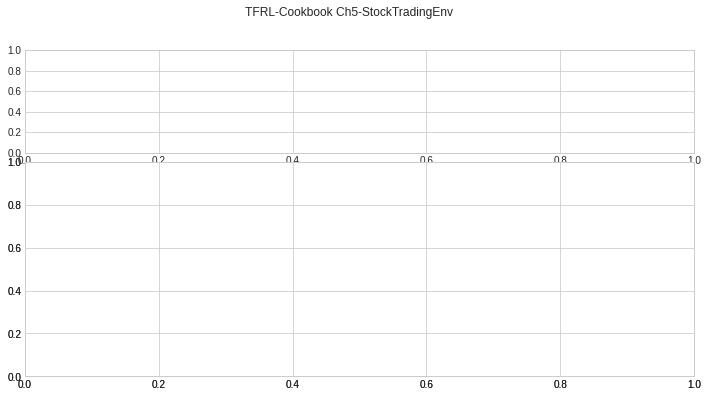

<ipython-input-5-a5d3355726c3>:132: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (current_cost + additional_cost) / (


In [6]:
if __name__ == "__main__":
    env = StockTradingContinuousEnv()
    obs = env.reset()
    num_episodes = 2  # Increase num_episodes
    for _ in range(num_episodes):
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        env.render()